<a href="https://colab.research.google.com/github/adrynalean/Summer_Projects/blob/Expression_recognizer/Any_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Setup and Load Data

### 1.1 Installing dependencies and Setting it all up

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import os

# this is to make my code device agnostic
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [ ]:
!pip install torch torchvision torchaudio opencv-python matplotlib

In [ ]:
import zipfile
import os
import shutil
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Function to extract zip files
def extract_zip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Define the paths
base_path = '/content/Data_AIC'
extract_base_path = '/content/extracted_data'

# Create base extraction path if it doesn't exist
os.makedirs(extract_base_path, exist_ok=True)

# List of emotions and corresponding zip files
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
zip_files = [os.path.join(base_path, f"{emotion}.zip") for emotion in emotions]

# Extract all zip files
for zip_file, emotion in zip(zip_files, emotions):
    emotion_path = os.path.join(extract_base_path, emotion)
    os.makedirs(emotion_path, exist_ok=True)  # Create emotion directory
    if os.path.exists(zip_file):
        extract_zip(zip_file, emotion_path)
    else:
        print(f"File not found: {zip_file}")

# Wait for extraction to complete
time.sleep(20)  # Adjust the sleep time as needed

# Verify the structure of the extracted folders
# print("Contents of extracted_data:")
# !ls /content/extracted_data
# print("Contents of angry directory:")
# !ls /content/extracted_data/angry

# Move images to subdirectories if needed
for emotion in emotions:
    emotion_path = os.path.join(extract_base_path, emotion)
    if os.path.exists(emotion_path):
        for filename in os.listdir(emotion_path):
            file_path = os.path.join(emotion_path, filename)
            if os.path.isfile(file_path):
                new_dir = os.path.join(emotion_path, 'class1')  # Move all images to a subdirectory named 'class1'
                os.makedirs(new_dir, exist_ok=True)
                shutil.move(file_path, os.path.join(new_dir, filename))

# Verify the structure again after moving files
# print("Contents of angry/class1 directory:")
# !ls /content/extracted_data/angry/class1

# Define a transformation to apply to the images
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a common size
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

# Load the datasets
datasets_dict = {}
for emotion in emotions:
    data_path = os.path.join(extract_base_path, emotion)
    datasets_dict[emotion] = datasets.ImageFolder(root=data_path, transform=data_transform)

# Combine all datasets into a single DataLoader
full_dataset = torch.utils.data.ConcatDataset([datasets_dict[emotion] for emotion in emotions])
data_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

# Check if the data is loaded correctly
for images, labels in data_loader:
    print(images.size(), labels.size())
    break


torch.Size([32, 3, 128, 128]) torch.Size([32])


### 1.2 Cleaning out Dodgy Images

In [ ]:
import cv2
import imghdr
import os

# Define the paths
extract_base_path = '/content/extracted_data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(extract_base_path):
    class_path = os.path.join(extract_base_path, image_class)
    if os.path.isdir(class_path):  # Ensure we're only processing directories
        for root, _, files in os.walk(class_path):
            for image in files:
                image_path = os.path.join(root, image)
                try:
                    img = cv2.imread(image_path)
                    tip = imghdr.what(image_path)
                    if tip not in image_exts:
                        print(f'Image not in ext list: {image_path}')
                        os.remove(image_path)
                except Exception as e:
                    print(f'Issue with image {image_path}: {e}')
                    # Optionally remove the image if it's problematic
                    # os.remove(image_path)


Image not in ext list: /content/extracted_data/happy/class1/vector8.svg
Image not in ext list: /content/extracted_data/happy/class1/traitshappypeople.jpg
Image not in ext list: /content/extracted_data/happy/class1/vector5.svg
Image not in ext list: /content/extracted_data/happy/class1/7-Habits-of-Happy-People.png
Image not in ext list: /content/extracted_data/happy/class1/smiling-woman_W6GFOSFAXA.jpg
Image not in ext list: /content/extracted_data/happy/class1/Happy20People.jpg
Image not in ext list: /content/extracted_data/happy/class1/depositphotos_391577690-stock-photo-cheerful-woman-outstretched-hands-sitting.jpg
Image not in ext list: /content/extracted_data/happy/class1/vector10.svg
Image not in ext list: /content/extracted_data/happy/class1/vector9.svg
Image not in ext list: /content/extracted_data/happy/class1/vector7.svg
Image not in ext list: /content/extracted_data/happy/class1/vector2.svg
Image not in ext list: /content/extracted_data/happy/class1/vector.svg
Image not in ext

In [ ]:
# Verify the cleaned structure of the extracted folders
# print("Contents of extracted_data after cleanup:")
# for emotion in emotions:
#     print(f"Contents of {emotion} directory:")
#     !ls /content/extracted_data/{emotion}/class1


### 1.3 Laoding Data, Sclaing it and visualizing it

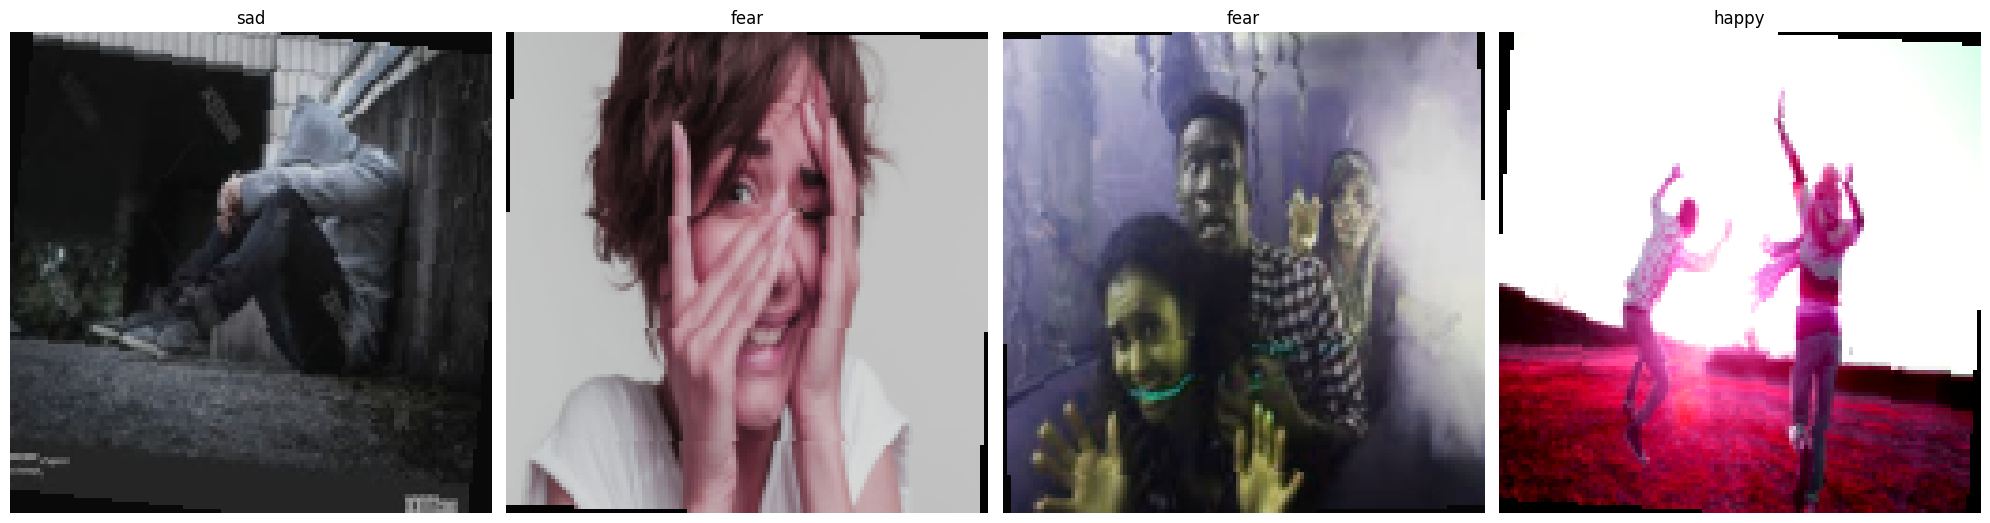

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])


# Load the datasets
data_path = '/content/extracted_data'
dataset = ImageFolder(root=data_path, transform=data_transform)

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get a batch of data
data_iterator = iter(data_loader)
batch = next(data_iterator)

# Plotting the images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20), tight_layout=True)
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax[idx].set_title(dataset.classes[batch[1][idx]])
    ax[idx].axis('off')  # Hide axes ticks

plt.show()


### 1.4 Splitting the Dataset

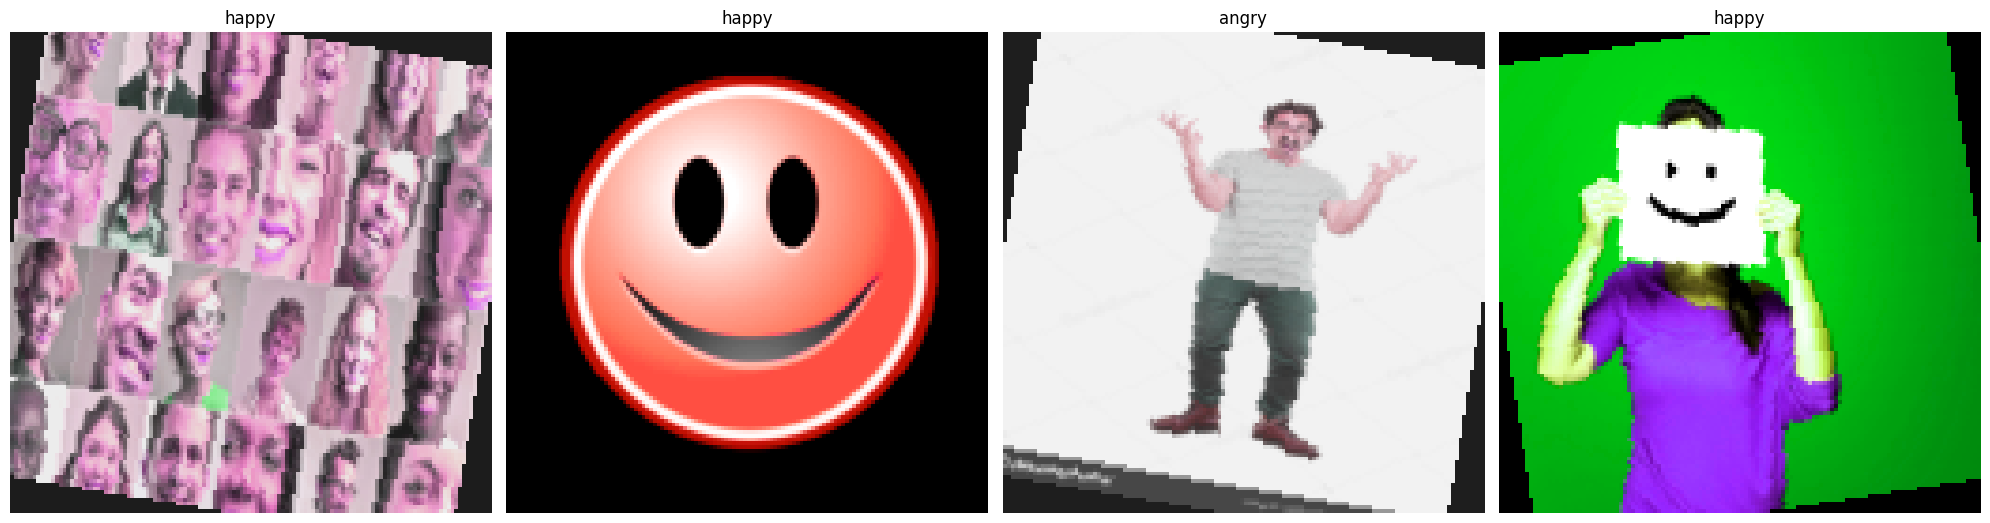

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# define the split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get a batch of data from the training set for visualization

train_data_iterator = iter(train_loader)
train_batch = next(train_data_iterator)


# Plotting the images from the training set
fig, ax = plt.subplots(ncols=4, figsize=(20, 20), tight_layout=True)
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax[idx].set_title(dataset.classes[train_batch[1][idx]])
    ax[idx].axis('off')  # Hide axes ticks

plt.show()


## 2. Let's make the Model!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class AICModel(nn.Module):
  def __init__(self):
    super(AICModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 16 * 16, 128)
    self.fc2 = nn.Linear(128, len(dataset.classes)) # number of classes

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 64 * 16 * 16)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# making the model device agnostic
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AICModel().to(device)

### 2.1 Setting up optimizer and loss functions

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

### 2.2 Let's Train The **Model**

In [ ]:
num_epochs = 5

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(num_epochs):

  ### Training
  model.train()
  running_loss = 0.0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    # 1. Optimizer zero grad
    optimizer.zero_grad()

    # 2. Forward pass
    outputs = model(images)

    # 3. Calculate the loss/accuracy
    loss = criterion(outputs, labels)

    # 4. Backpropogation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # loss accumulation
    running_loss += loss.item()

  # scheduler.step()

  print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')



Epoch 1/5, Loss: 0.4242965859525344
Epoch 2/5, Loss: 0.3551829492344576
Epoch 3/5, Loss: 0.3631177597186145
Epoch 4/5, Loss: 0.35205667246790495
Epoch 5/5, Loss: 0.3534780188518412


In [ ]:
# Evalute our Model

model.eval()

correct = 0
total = 0

with torch.inference_mode():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy: { 100 * correct /total}%')

Accuracy: 64.23357664233576%


### 2.3 Visualize Visualize Visualize

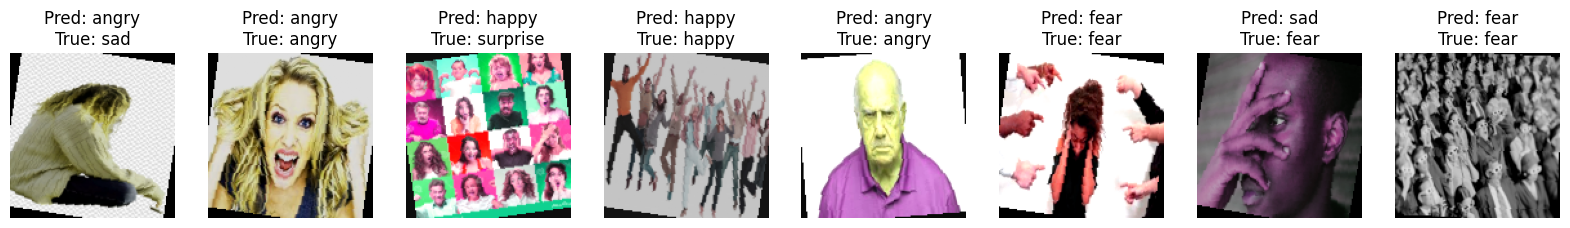

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Function to visualize test cases
def visualize_test_cases(model, test_loader, num_images=8):
    model.eval()
    data_iterator = iter(test_loader)
    images, labels = next(data_iterator)
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for idx in range(num_images):
        ax = axes[idx]
        img = np.transpose(images[idx], (1, 2, 0))  # Convert CHW to HWC
        ax.imshow(img)
        ax.set_title(f'Pred: {dataset.classes[predicted[idx]]}\nTrue: {dataset.classes[labels[idx]]}')
        ax.axis('off')
    plt.show()

# Visualize test cases
visualize_test_cases(model, test_loader, num_images=8)

## Visualization is the key to ML in my opinion that is why there is visualization everywhere in it
